<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Продвинутые методы классификации и регрессии. Xgboost</center>
## <center>Практика. Настройка Xgboost в задаче регрессии. Решение</center>

In [1]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%pylab inline
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


**Считаем данные.**

In [2]:
data = load_boston()
X, y = pd.DataFrame(data['data'], columns=data['feature_names']), data['target']

(array([  21.,   55.,   82.,  154.,   84.,   41.,   30.,    8.,   10.,   21.]),
 array([  5. ,   9.5,  14. ,  18.5,  23. ,  27.5,  32. ,  36.5,  41. ,
         45.5,  50. ]),
 <a list of 10 Patch objects>)

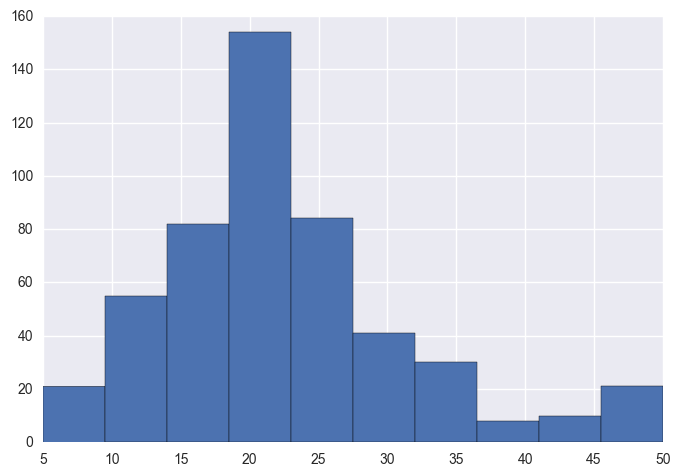

In [12]:
hist(y)

**Оставим 30% данных на финальную проверку моделей.**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=7)

**Зафиксируем объект StratifiedKFold, с его помощью будет проводить кросс-валидацию.**

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

**Используйте sklearn-обертку Xgboost для оценки RMSE на кросс-валидации с данными (X_train, y_train). Пока оставьте параметры XGBRegressor по умолчанию (только seed=7, это то же по сути, что random_state). Выведите среднюю RMSE на кросс-вадидации, используйте ранее созданный объект StratifiedKFold.**

In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [7]:
xgb_model1 = XGBRegressor(seed=7)

In [8]:
%%time
np.sqrt(np.mean(np.abs(cross_val_score(xgb_model1, X_train, y_train, cv=skf,
                       scoring='neg_mean_squared_error'))))

CPU times: user 515 ms, sys: 516 ms, total: 1.03 s
Wall time: 715 ms


3.7182205637223946

**Обучите модель на (X_train, y_train) и выведите оценку важности признаков (plot_importance из xgboost).**

In [9]:
from xgboost import plot_importance

In [10]:
xgb_model1.fit(X_train, y_train);

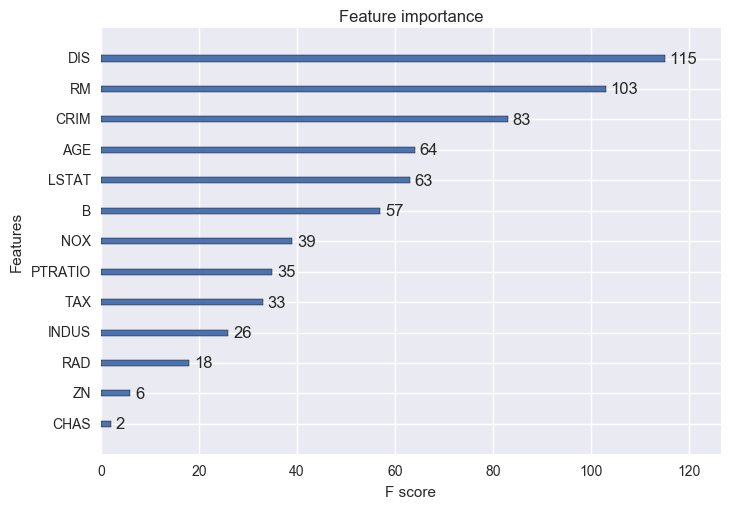

In [10]:
plot_importance(xgb_model1);

**Постройте кривые валидации по глубине деревьев от 2 до 7. Все прочие параметры кросс-валидации возьмите как на предыдущем шаге. Достаточно сохранять только среднюю RMSE на валидационной части (на обучающей – не надо).**

In [11]:
%%time
tree_depths = np.arange(2,8)
xgb_scores = []
for depth in tree_depths:
    print(depth, end=' ')
    xgb_model = XGBRegressor(max_depth=depth, seed=7)
    xgb_cv_score = np.sqrt(np.mean(np.abs(cross_val_score(xgb_model, X_train, y_train, cv=skf,
                                              scoring='neg_mean_squared_error'))))
    xgb_scores.append(xgb_cv_score)

2 3 4 5 6 7 CPU times: user 3.61 s, sys: 4.42 s, total: 8.02 s
Wall time: 5.45 s


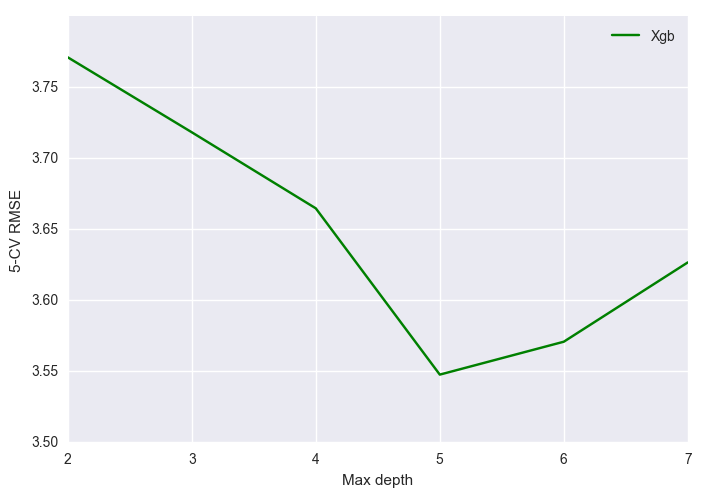

In [12]:
plot(tree_depths, xgb_scores, color='green', label='Xgb');
xlabel('Max depth')
ylabel('5-CV RMSE')
legend();

**Используйте RandomizedGridSearch, чтобы настроить параметры бустинга. Задайте 10 итераций (будут перебираться случайные 10 комбинаций параметров), а кросс-валидацию – как ранее. Выведите лучшие параметры и RMSE (поля best\_params\_ и best\_score\_ у обученного RandomizedGridSearch).**

In [13]:
from sklearn.model_selection import RandomizedSearchCV

In [14]:
xgb_params_dist_grid = {
    'max_depth': [2, 4, 5, 6],
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': [0.5, 0.75, 1.],
    'colsample_bytree': [0.5, 0.75, 1.]
}
xgb_params_fixed = {
    'objective': 'reg:linear',
    'silent': 1,
    'seed': 7
}

In [15]:
xgb_grid = RandomizedSearchCV(
    estimator=XGBRegressor(**xgb_params_fixed),
    param_distributions=xgb_params_dist_grid,
    n_iter=10,
    cv=skf,
    scoring='neg_mean_squared_error',
    random_state=7,
)

In [16]:
%%time
xgb_grid.fit(X_train, y_train);

CPU times: user 5.8 s, sys: 7.39 s, total: 13.2 s
Wall time: 9.61 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
          error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=1, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'colsample_bytree': [0.5, 0.75, 1.0], 'subsample': [0.5, 0.75, 1.0], 'gamma': array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ]), 'max_depth': [2, 4, 5, 6]},
          pre_dispatch='2*n_jobs', random_state=7, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [17]:
xgb_grid.best_params_

{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'subsample': 0.75}

In [18]:
np.sqrt(np.abs(xgb_grid.best_score_))

3.3824927654290025

**Проверьте RMSE бустинга на оставленной выборке. Сравните две версии бустинга – ненастроенную и настроенную.**

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
np.sqrt(mean_squared_error(y_test, xgb_model1.predict(X_test)))

3.2812023369792027

In [41]:
np.sqrt(mean_squared_error(y_test, xgb_grid.predict(X_test)))

3.1442273946231092